In [1]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import torchvision.transforms as transforms


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
log_dir = "/home/asad/catkin_ws2/src/turtlebot3_activeSLAM/dqn_controller/log/"

In [4]:
dir_list = [d for d in os.listdir(log_dir) if d.find("2023") != -1]
scans_list = [np.load(log_dir + d + "/scans.npy") for d in dir_list]

In [5]:
scans = np.concatenate(scans_list, axis = 0)
scans = scans.reshape(-1, 360)


INF_SCAN_DISTANCE = 3.5# + 0.5

scans = np.nan_to_num(scans, posinf=INF_SCAN_DISTANCE)
scans = np.roll(scans, 180, axis=-1)
scans /= INF_SCAN_DISTANCE

scans = torch.from_numpy(scans).to(torch.float32).to(device)

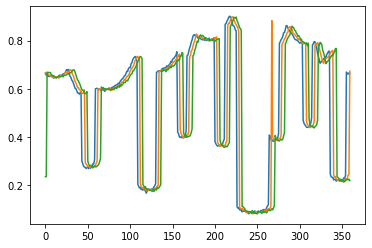

In [6]:
plt.plot(scans[5].cpu())
plt.plot(scans[6].cpu())
plt.plot(scans[7].cpu())
plt.show()

In [7]:
train_data, test_data = train_test_split(scans, test_size=0.2, shuffle=True)

In [8]:
class EncoderScan360(nn.Module):
    def __init__(self) -> None:
        super(EncoderScan360, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 4, kernel_size=5),
            nn.ReLU(),
            nn.Conv1d(4, 4, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(4, 8, kernel_size=5),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(8, 16, kernel_size=4),
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(16, 32, kernel_size=5),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size=5),
            nn.ReLU(),

            nn.Flatten()
        )

    def forward(self, x):
        x = x.reshape(-1, 1, 360)
        x = self.encoder(x)
        return x


encoder = EncoderScan360()
m = torch.rand(10, 360)
encoder(m).shape

torch.Size([10, 32])

In [9]:
class DecoderScan360(nn.Module):
    def __init__(self) -> None:
        super(DecoderScan360, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 32, kernel_size=5),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=5),
            nn.ReLU(),
            nn.Upsample(scale_factor=4),

            nn.ConvTranspose1d(16, 16, kernel_size=4),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 8, kernel_size=4),
            nn.ReLU(),
            nn.Upsample(scale_factor=4),

            nn.ConvTranspose1d(8, 8, kernel_size=5),
            nn.ReLU(),
            nn.ConvTranspose1d(8, 4, kernel_size=5),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.ConvTranspose1d(4, 4, kernel_size=5),
            nn.ReLU(),
            nn.ConvTranspose1d(4, 1, kernel_size=5),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.reshape(-1, 32, 1)
        x = self.decoder(x)
        x = x.reshape(-1, 360)
        return x


decoder = DecoderScan360()
m = torch.rand(10, 32)
decoder(m).shape

torch.Size([10, 360])

In [10]:
class AutoencoderScan360(nn.Module):
    def __init__(self) -> None:
        super(AutoencoderScan360, self).__init__()
        self.encoder = EncoderScan360()
        self.decoder = DecoderScan360()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x


autoencoder = AutoencoderScan360()
m = torch.rand(10, 360)

In [11]:
cirterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


In [12]:
autoencoder = autoencoder.to(device)

In [13]:
train_dataset = data_utils.TensorDataset(train_data)
test_dataset = data_utils.TensorDataset(test_data)

train_data_loader = data_utils.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_data_loader = data_utils.DataLoader(test_dataset, batch_size=128, shuffle=True)

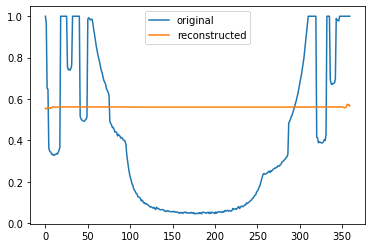

In [14]:
def plot_result(index = -1):
    if index == -1:
      index = np.random.randint(len(test_data))


    with torch.no_grad():
        result = autoencoder(test_data[index])

    plt.plot(test_data[index].cpu().squeeze(), label="original")
    plt.plot(result[0].cpu().squeeze(), label="reconstructed")

    plt.legend()
    plt.show()

plot_result()

Epoch [1/100], Step [50/400], Loss: 0.086619
Epoch [1/100], Step [100/400], Loss: 0.082963
Epoch [1/100], Step [150/400], Loss: 0.072404
Epoch [1/100], Step [200/400], Loss: 0.049007
Epoch [1/100], Step [250/400], Loss: 0.042175
Epoch [1/100], Step [300/400], Loss: 0.038864
Epoch [1/100], Step [350/400], Loss: 0.035224
Epoch [1/100], Step [400/400], Loss: 0.032231
Epoch [1/100], Average Train Loss: 0.059072, Average Test Loss: 0.033592
Epoch [2/100], Step [50/400], Loss: 0.031231
Epoch [2/100], Step [100/400], Loss: 0.029628
Epoch [2/100], Step [150/400], Loss: 0.029186
Epoch [2/100], Step [200/400], Loss: 0.029683
Epoch [2/100], Step [250/400], Loss: 0.028205
Epoch [2/100], Step [300/400], Loss: 0.028687
Epoch [2/100], Step [350/400], Loss: 0.028362
Epoch [2/100], Step [400/400], Loss: 0.026277
Epoch [2/100], Average Train Loss: 0.029429, Average Test Loss: 0.026821
Epoch [3/100], Step [50/400], Loss: 0.025212
Epoch [3/100], Step [100/400], Loss: 0.026045
Epoch [3/100], Step [150/400]

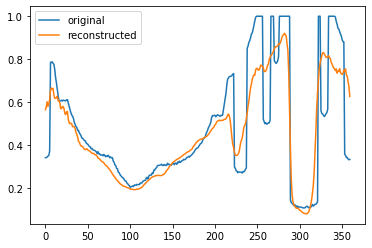

Epoch [6/100], Step [50/400], Loss: 0.019068
Epoch [6/100], Step [100/400], Loss: 0.018770
Epoch [6/100], Step [150/400], Loss: 0.018895
Epoch [6/100], Step [200/400], Loss: 0.019484
Epoch [6/100], Step [250/400], Loss: 0.018944
Epoch [6/100], Step [300/400], Loss: 0.018162
Epoch [6/100], Step [350/400], Loss: 0.017880
Epoch [6/100], Step [400/400], Loss: 0.018120
Epoch [6/100], Average Train Loss: 0.018856, Average Test Loss: 0.018332
Epoch [7/100], Step [50/400], Loss: 0.017865
Epoch [7/100], Step [100/400], Loss: 0.017607
Epoch [7/100], Step [150/400], Loss: 0.017297
Epoch [7/100], Step [200/400], Loss: 0.017580
Epoch [7/100], Step [250/400], Loss: 0.017958
Epoch [7/100], Step [300/400], Loss: 0.017866
Epoch [7/100], Step [350/400], Loss: 0.016746
Epoch [7/100], Step [400/400], Loss: 0.016170
Epoch [7/100], Average Train Loss: 0.017720, Average Test Loss: 0.017414
Epoch [8/100], Step [50/400], Loss: 0.016568
Epoch [8/100], Step [100/400], Loss: 0.017318
Epoch [8/100], Step [150/400]

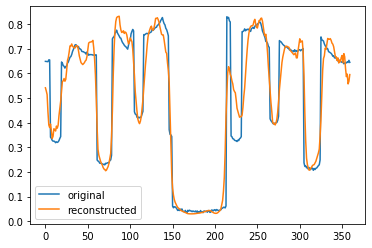

Epoch [11/100], Step [50/400], Loss: 0.015015
Epoch [11/100], Step [100/400], Loss: 0.015514
Epoch [11/100], Step [150/400], Loss: 0.014325
Epoch [11/100], Step [200/400], Loss: 0.014609
Epoch [11/100], Step [250/400], Loss: 0.014158
Epoch [11/100], Step [300/400], Loss: 0.013775
Epoch [11/100], Step [350/400], Loss: 0.014917
Epoch [11/100], Step [400/400], Loss: 0.014455
Epoch [11/100], Average Train Loss: 0.014630, Average Test Loss: 0.014282
Epoch [12/100], Step [50/400], Loss: 0.014481
Epoch [12/100], Step [100/400], Loss: 0.014157
Epoch [12/100], Step [150/400], Loss: 0.013979
Epoch [12/100], Step [200/400], Loss: 0.014210
Epoch [12/100], Step [250/400], Loss: 0.014155
Epoch [12/100], Step [300/400], Loss: 0.013613
Epoch [12/100], Step [350/400], Loss: 0.013137
Epoch [12/100], Step [400/400], Loss: 0.013942
Epoch [12/100], Average Train Loss: 0.014103, Average Test Loss: 0.013818
Epoch [13/100], Step [50/400], Loss: 0.013419
Epoch [13/100], Step [100/400], Loss: 0.013751
Epoch [13

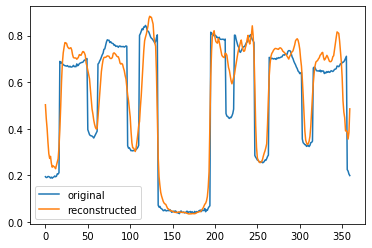

Epoch [16/100], Step [50/400], Loss: 0.013169
Epoch [16/100], Step [100/400], Loss: 0.013053
Epoch [16/100], Step [150/400], Loss: 0.012984
Epoch [16/100], Step [200/400], Loss: 0.012833
Epoch [16/100], Step [250/400], Loss: 0.012633
Epoch [16/100], Step [300/400], Loss: 0.013110
Epoch [16/100], Step [350/400], Loss: 0.012669
Epoch [16/100], Step [400/400], Loss: 0.011937
Epoch [16/100], Average Train Loss: 0.012780, Average Test Loss: 0.012895
Epoch [17/100], Step [50/400], Loss: 0.012850
Epoch [17/100], Step [100/400], Loss: 0.012187
Epoch [17/100], Step [150/400], Loss: 0.012904
Epoch [17/100], Step [200/400], Loss: 0.012798
Epoch [17/100], Step [250/400], Loss: 0.012103
Epoch [17/100], Step [300/400], Loss: 0.012329
Epoch [17/100], Step [350/400], Loss: 0.012273
Epoch [17/100], Step [400/400], Loss: 0.012822
Epoch [17/100], Average Train Loss: 0.012520, Average Test Loss: 0.012539
Epoch [18/100], Step [50/400], Loss: 0.012697
Epoch [18/100], Step [100/400], Loss: 0.011674
Epoch [18

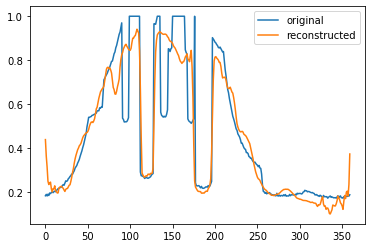

Epoch [21/100], Step [50/400], Loss: 0.011623
Epoch [21/100], Step [100/400], Loss: 0.012000
Epoch [21/100], Step [150/400], Loss: 0.012137
Epoch [21/100], Step [200/400], Loss: 0.012186
Epoch [21/100], Step [250/400], Loss: 0.011416
Epoch [21/100], Step [300/400], Loss: 0.011874
Epoch [21/100], Step [350/400], Loss: 0.011568
Epoch [21/100], Step [400/400], Loss: 0.010971
Epoch [21/100], Average Train Loss: 0.011767, Average Test Loss: 0.011821
Epoch [22/100], Step [50/400], Loss: 0.011244
Epoch [22/100], Step [100/400], Loss: 0.011383
Epoch [22/100], Step [150/400], Loss: 0.011879
Epoch [22/100], Step [200/400], Loss: 0.012183
Epoch [22/100], Step [250/400], Loss: 0.011436
Epoch [22/100], Step [300/400], Loss: 0.011860
Epoch [22/100], Step [350/400], Loss: 0.012159
Epoch [22/100], Step [400/400], Loss: 0.011299
Epoch [22/100], Average Train Loss: 0.011589, Average Test Loss: 0.011424
Epoch [23/100], Step [50/400], Loss: 0.011709
Epoch [23/100], Step [100/400], Loss: 0.011588
Epoch [23

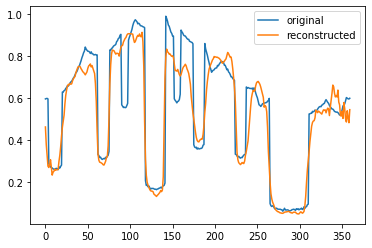

Epoch [26/100], Step [50/400], Loss: 0.010802
Epoch [26/100], Step [100/400], Loss: 0.010674
Epoch [26/100], Step [150/400], Loss: 0.011140
Epoch [26/100], Step [200/400], Loss: 0.011080
Epoch [26/100], Step [250/400], Loss: 0.010807
Epoch [26/100], Step [300/400], Loss: 0.011117
Epoch [26/100], Step [350/400], Loss: 0.011451
Epoch [26/100], Step [400/400], Loss: 0.011437
Epoch [26/100], Average Train Loss: 0.011103, Average Test Loss: 0.011194
Epoch [27/100], Step [50/400], Loss: 0.011367
Epoch [27/100], Step [100/400], Loss: 0.010922
Epoch [27/100], Step [150/400], Loss: 0.011185
Epoch [27/100], Step [200/400], Loss: 0.010851
Epoch [27/100], Step [250/400], Loss: 0.010586
Epoch [27/100], Step [300/400], Loss: 0.010808
Epoch [27/100], Step [350/400], Loss: 0.010457
Epoch [27/100], Step [400/400], Loss: 0.011418
Epoch [27/100], Average Train Loss: 0.011016, Average Test Loss: 0.011143
Epoch [28/100], Step [50/400], Loss: 0.010924
Epoch [28/100], Step [100/400], Loss: 0.011041
Epoch [28

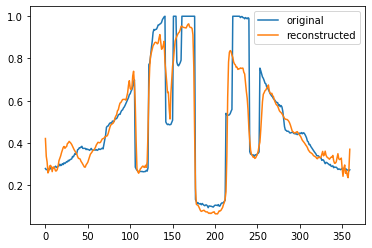

Epoch [31/100], Step [50/400], Loss: 0.010652
Epoch [31/100], Step [100/400], Loss: 0.010198
Epoch [31/100], Step [150/400], Loss: 0.010652
Epoch [31/100], Step [200/400], Loss: 0.011087
Epoch [31/100], Step [250/400], Loss: 0.010646
Epoch [31/100], Step [300/400], Loss: 0.010481
Epoch [31/100], Step [350/400], Loss: 0.010728
Epoch [31/100], Step [400/400], Loss: 0.010974
Epoch [31/100], Average Train Loss: 0.010598, Average Test Loss: 0.010567
Epoch [32/100], Step [50/400], Loss: 0.010346
Epoch [32/100], Step [100/400], Loss: 0.011407
Epoch [32/100], Step [150/400], Loss: 0.010509
Epoch [32/100], Step [200/400], Loss: 0.010070
Epoch [32/100], Step [250/400], Loss: 0.010706
Epoch [32/100], Step [300/400], Loss: 0.010970
Epoch [32/100], Step [350/400], Loss: 0.010697
Epoch [32/100], Step [400/400], Loss: 0.010586
Epoch [32/100], Average Train Loss: 0.010517, Average Test Loss: 0.010476
Epoch [33/100], Step [50/400], Loss: 0.010282
Epoch [33/100], Step [100/400], Loss: 0.010461
Epoch [33

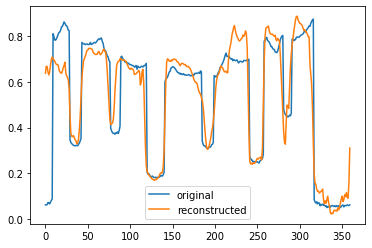

Epoch [36/100], Step [50/400], Loss: 0.010102
Epoch [36/100], Step [100/400], Loss: 0.010058
Epoch [36/100], Step [150/400], Loss: 0.010481
Epoch [36/100], Step [200/400], Loss: 0.009696
Epoch [36/100], Step [250/400], Loss: 0.010069
Epoch [36/100], Step [300/400], Loss: 0.010703
Epoch [36/100], Step [350/400], Loss: 0.010229
Epoch [36/100], Step [400/400], Loss: 0.010245
Epoch [36/100], Average Train Loss: 0.010184, Average Test Loss: 0.010222
Epoch [37/100], Step [50/400], Loss: 0.009846
Epoch [37/100], Step [100/400], Loss: 0.010785
Epoch [37/100], Step [150/400], Loss: 0.009999
Epoch [37/100], Step [200/400], Loss: 0.010149
Epoch [37/100], Step [250/400], Loss: 0.010587
Epoch [37/100], Step [300/400], Loss: 0.010254
Epoch [37/100], Step [350/400], Loss: 0.009966
Epoch [37/100], Step [400/400], Loss: 0.011269
Epoch [37/100], Average Train Loss: 0.010112, Average Test Loss: 0.010115
Epoch [38/100], Step [50/400], Loss: 0.009968
Epoch [38/100], Step [100/400], Loss: 0.009821
Epoch [38

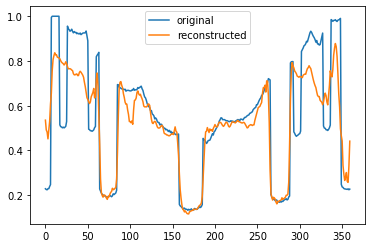

Epoch [41/100], Step [50/400], Loss: 0.009744
Epoch [41/100], Step [100/400], Loss: 0.010021
Epoch [41/100], Step [150/400], Loss: 0.009980
Epoch [41/100], Step [200/400], Loss: 0.009851
Epoch [41/100], Step [250/400], Loss: 0.010008
Epoch [41/100], Step [300/400], Loss: 0.009695
Epoch [41/100], Step [350/400], Loss: 0.009545
Epoch [41/100], Step [400/400], Loss: 0.009615
Epoch [41/100], Average Train Loss: 0.009853, Average Test Loss: 0.009859
Epoch [42/100], Step [50/400], Loss: 0.010094
Epoch [42/100], Step [100/400], Loss: 0.009955
Epoch [42/100], Step [150/400], Loss: 0.010265
Epoch [42/100], Step [200/400], Loss: 0.009877
Epoch [42/100], Step [250/400], Loss: 0.009412
Epoch [42/100], Step [300/400], Loss: 0.010375
Epoch [42/100], Step [350/400], Loss: 0.010116
Epoch [42/100], Step [400/400], Loss: 0.009760
Epoch [42/100], Average Train Loss: 0.009772, Average Test Loss: 0.009874
Epoch [43/100], Step [50/400], Loss: 0.009757
Epoch [43/100], Step [100/400], Loss: 0.009584
Epoch [43

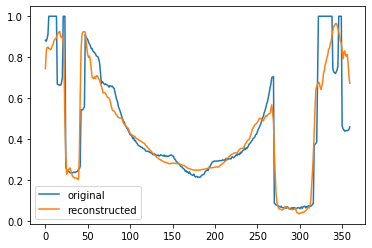

Epoch [46/100], Step [50/400], Loss: 0.009605
Epoch [46/100], Step [100/400], Loss: 0.009217
Epoch [46/100], Step [150/400], Loss: 0.009347
Epoch [46/100], Step [200/400], Loss: 0.009504
Epoch [46/100], Step [250/400], Loss: 0.009134
Epoch [46/100], Step [300/400], Loss: 0.009712
Epoch [46/100], Step [350/400], Loss: 0.009452
Epoch [46/100], Step [400/400], Loss: 0.009215
Epoch [46/100], Average Train Loss: 0.009518, Average Test Loss: 0.009490
Epoch [47/100], Step [50/400], Loss: 0.009137
Epoch [47/100], Step [100/400], Loss: 0.009227
Epoch [47/100], Step [150/400], Loss: 0.009411
Epoch [47/100], Step [200/400], Loss: 0.009602
Epoch [47/100], Step [250/400], Loss: 0.009569
Epoch [47/100], Step [300/400], Loss: 0.009630
Epoch [47/100], Step [350/400], Loss: 0.009607
Epoch [47/100], Step [400/400], Loss: 0.009438
Epoch [47/100], Average Train Loss: 0.009522, Average Test Loss: 0.009664
Epoch [48/100], Step [50/400], Loss: 0.009167
Epoch [48/100], Step [100/400], Loss: 0.009139
Epoch [48

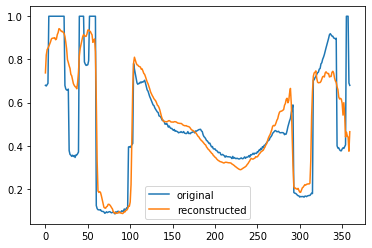

Epoch [51/100], Step [50/400], Loss: 0.009330
Epoch [51/100], Step [100/400], Loss: 0.009630
Epoch [51/100], Step [150/400], Loss: 0.009483
Epoch [51/100], Step [200/400], Loss: 0.009647
Epoch [51/100], Step [250/400], Loss: 0.008992
Epoch [51/100], Step [300/400], Loss: 0.009360
Epoch [51/100], Step [350/400], Loss: 0.009000
Epoch [51/100], Step [400/400], Loss: 0.008948
Epoch [51/100], Average Train Loss: 0.009297, Average Test Loss: 0.009335
Epoch [52/100], Step [50/400], Loss: 0.009118
Epoch [52/100], Step [100/400], Loss: 0.009251
Epoch [52/100], Step [150/400], Loss: 0.008992
Epoch [52/100], Step [200/400], Loss: 0.009570
Epoch [52/100], Step [250/400], Loss: 0.009081
Epoch [52/100], Step [300/400], Loss: 0.009155
Epoch [52/100], Step [350/400], Loss: 0.009397
Epoch [52/100], Step [400/400], Loss: 0.009151
Epoch [52/100], Average Train Loss: 0.009247, Average Test Loss: 0.009297
Epoch [53/100], Step [50/400], Loss: 0.009522
Epoch [53/100], Step [100/400], Loss: 0.009218
Epoch [53

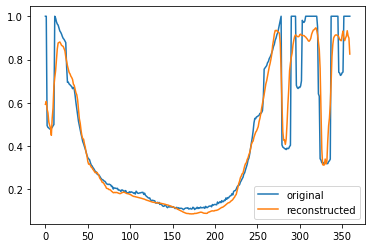

Epoch [56/100], Step [50/400], Loss: 0.009537
Epoch [56/100], Step [100/400], Loss: 0.008665
Epoch [56/100], Step [150/400], Loss: 0.009042
Epoch [56/100], Step [200/400], Loss: 0.009284
Epoch [56/100], Step [250/400], Loss: 0.009318
Epoch [56/100], Step [300/400], Loss: 0.009202
Epoch [56/100], Step [350/400], Loss: 0.008672
Epoch [56/100], Step [400/400], Loss: 0.009070
Epoch [56/100], Average Train Loss: 0.009089, Average Test Loss: 0.009221
Epoch [57/100], Step [50/400], Loss: 0.008874
Epoch [57/100], Step [100/400], Loss: 0.008887
Epoch [57/100], Step [150/400], Loss: 0.008645
Epoch [57/100], Step [200/400], Loss: 0.009142
Epoch [57/100], Step [250/400], Loss: 0.008981
Epoch [57/100], Step [300/400], Loss: 0.009126
Epoch [57/100], Step [350/400], Loss: 0.008791
Epoch [57/100], Step [400/400], Loss: 0.008718
Epoch [57/100], Average Train Loss: 0.009061, Average Test Loss: 0.008991
Epoch [58/100], Step [50/400], Loss: 0.009179
Epoch [58/100], Step [100/400], Loss: 0.009116
Epoch [58

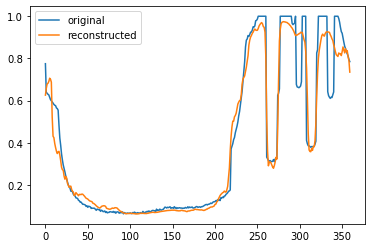

Epoch [61/100], Step [50/400], Loss: 0.009000
Epoch [61/100], Step [100/400], Loss: 0.008766
Epoch [61/100], Step [150/400], Loss: 0.009026
Epoch [61/100], Step [200/400], Loss: 0.008809
Epoch [61/100], Step [250/400], Loss: 0.008757
Epoch [61/100], Step [300/400], Loss: 0.008803
Epoch [61/100], Step [350/400], Loss: 0.008977
Epoch [61/100], Step [400/400], Loss: 0.008697
Epoch [61/100], Average Train Loss: 0.008857, Average Test Loss: 0.009023
Epoch [62/100], Step [50/400], Loss: 0.008981
Epoch [62/100], Step [100/400], Loss: 0.008488
Epoch [62/100], Step [150/400], Loss: 0.009216
Epoch [62/100], Step [200/400], Loss: 0.008570
Epoch [62/100], Step [250/400], Loss: 0.008622
Epoch [62/100], Step [300/400], Loss: 0.008422
Epoch [62/100], Step [350/400], Loss: 0.008882
Epoch [62/100], Step [400/400], Loss: 0.009042
Epoch [62/100], Average Train Loss: 0.008828, Average Test Loss: 0.009024
Epoch [63/100], Step [50/400], Loss: 0.008837
Epoch [63/100], Step [100/400], Loss: 0.009030
Epoch [63

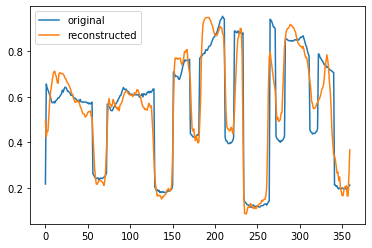

Epoch [66/100], Step [50/400], Loss: 0.008262
Epoch [66/100], Step [100/400], Loss: 0.008311
Epoch [66/100], Step [150/400], Loss: 0.008929
Epoch [66/100], Step [200/400], Loss: 0.008447
Epoch [66/100], Step [250/400], Loss: 0.008545
Epoch [66/100], Step [300/400], Loss: 0.008872
Epoch [66/100], Step [350/400], Loss: 0.009257
Epoch [66/100], Step [400/400], Loss: 0.008308
Epoch [66/100], Average Train Loss: 0.008697, Average Test Loss: 0.008728
Epoch [67/100], Step [50/400], Loss: 0.009448
Epoch [67/100], Step [100/400], Loss: 0.009204
Epoch [67/100], Step [150/400], Loss: 0.008573
Epoch [67/100], Step [200/400], Loss: 0.008326
Epoch [67/100], Step [250/400], Loss: 0.008215
Epoch [67/100], Step [300/400], Loss: 0.009390
Epoch [67/100], Step [350/400], Loss: 0.008290
Epoch [67/100], Step [400/400], Loss: 0.008756
Epoch [67/100], Average Train Loss: 0.008677, Average Test Loss: 0.008673
Epoch [68/100], Step [50/400], Loss: 0.008432
Epoch [68/100], Step [100/400], Loss: 0.008518
Epoch [68

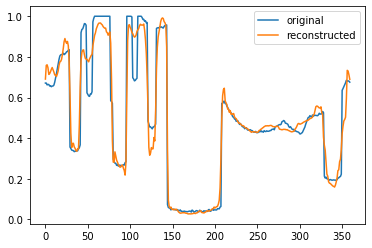

Epoch [71/100], Step [50/400], Loss: 0.008507
Epoch [71/100], Step [100/400], Loss: 0.008937
Epoch [71/100], Step [150/400], Loss: 0.008118
Epoch [71/100], Step [200/400], Loss: 0.008282
Epoch [71/100], Step [250/400], Loss: 0.008690
Epoch [71/100], Step [300/400], Loss: 0.008802
Epoch [71/100], Step [350/400], Loss: 0.008587
Epoch [71/100], Step [400/400], Loss: 0.008344
Epoch [71/100], Average Train Loss: 0.008534, Average Test Loss: 0.008615
Epoch [72/100], Step [50/400], Loss: 0.008039
Epoch [72/100], Step [100/400], Loss: 0.008290
Epoch [72/100], Step [150/400], Loss: 0.008413
Epoch [72/100], Step [200/400], Loss: 0.008970
Epoch [72/100], Step [250/400], Loss: 0.008666
Epoch [72/100], Step [300/400], Loss: 0.008101
Epoch [72/100], Step [350/400], Loss: 0.008628
Epoch [72/100], Step [400/400], Loss: 0.008459
Epoch [72/100], Average Train Loss: 0.008498, Average Test Loss: 0.008563
Epoch [73/100], Step [50/400], Loss: 0.008836
Epoch [73/100], Step [100/400], Loss: 0.008585
Epoch [73

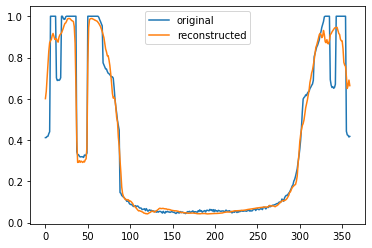

Epoch [76/100], Step [50/400], Loss: 0.008737
Epoch [76/100], Step [100/400], Loss: 0.008361
Epoch [76/100], Step [150/400], Loss: 0.008444
Epoch [76/100], Step [200/400], Loss: 0.008266
Epoch [76/100], Step [250/400], Loss: 0.007838
Epoch [76/100], Step [300/400], Loss: 0.008794
Epoch [76/100], Step [350/400], Loss: 0.008259
Epoch [76/100], Step [400/400], Loss: 0.008733
Epoch [76/100], Average Train Loss: 0.008427, Average Test Loss: 0.008332
Epoch [77/100], Step [50/400], Loss: 0.008564
Epoch [77/100], Step [100/400], Loss: 0.008761
Epoch [77/100], Step [150/400], Loss: 0.008386
Epoch [77/100], Step [200/400], Loss: 0.007949
Epoch [77/100], Step [250/400], Loss: 0.008433
Epoch [77/100], Step [300/400], Loss: 0.007958
Epoch [77/100], Step [350/400], Loss: 0.008283
Epoch [77/100], Step [400/400], Loss: 0.008464
Epoch [77/100], Average Train Loss: 0.008353, Average Test Loss: 0.008406
Epoch [78/100], Step [50/400], Loss: 0.008648
Epoch [78/100], Step [100/400], Loss: 0.008193
Epoch [78

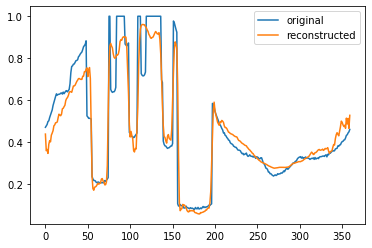

Epoch [81/100], Step [50/400], Loss: 0.008082
Epoch [81/100], Step [100/400], Loss: 0.008190
Epoch [81/100], Step [150/400], Loss: 0.008309
Epoch [81/100], Step [200/400], Loss: 0.008113
Epoch [81/100], Step [250/400], Loss: 0.008147
Epoch [81/100], Step [300/400], Loss: 0.008117
Epoch [81/100], Step [350/400], Loss: 0.008085
Epoch [81/100], Step [400/400], Loss: 0.008067
Epoch [81/100], Average Train Loss: 0.008251, Average Test Loss: 0.008401
Epoch [82/100], Step [50/400], Loss: 0.008396
Epoch [82/100], Step [100/400], Loss: 0.008481
Epoch [82/100], Step [150/400], Loss: 0.008134
Epoch [82/100], Step [200/400], Loss: 0.008225
Epoch [82/100], Step [250/400], Loss: 0.008043
Epoch [82/100], Step [300/400], Loss: 0.008381
Epoch [82/100], Step [350/400], Loss: 0.008485
Epoch [82/100], Step [400/400], Loss: 0.007932
Epoch [82/100], Average Train Loss: 0.008243, Average Test Loss: 0.008330
Epoch [83/100], Step [50/400], Loss: 0.008409
Epoch [83/100], Step [100/400], Loss: 0.008067
Epoch [83

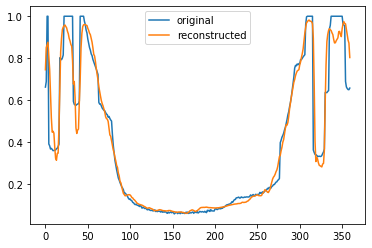

Epoch [86/100], Step [50/400], Loss: 0.008249
Epoch [86/100], Step [100/400], Loss: 0.007923
Epoch [86/100], Step [150/400], Loss: 0.007960
Epoch [86/100], Step [200/400], Loss: 0.008057
Epoch [86/100], Step [250/400], Loss: 0.007774
Epoch [86/100], Step [300/400], Loss: 0.008150
Epoch [86/100], Step [350/400], Loss: 0.008297
Epoch [86/100], Step [400/400], Loss: 0.009012
Epoch [86/100], Average Train Loss: 0.008131, Average Test Loss: 0.008388
Epoch [87/100], Step [50/400], Loss: 0.008017
Epoch [87/100], Step [100/400], Loss: 0.008014
Epoch [87/100], Step [150/400], Loss: 0.007845
Epoch [87/100], Step [200/400], Loss: 0.008143
Epoch [87/100], Step [250/400], Loss: 0.008436
Epoch [87/100], Step [300/400], Loss: 0.008069
Epoch [87/100], Step [350/400], Loss: 0.008126
Epoch [87/100], Step [400/400], Loss: 0.008138
Epoch [87/100], Average Train Loss: 0.008114, Average Test Loss: 0.008238
Epoch [88/100], Step [50/400], Loss: 0.007887
Epoch [88/100], Step [100/400], Loss: 0.008310
Epoch [88

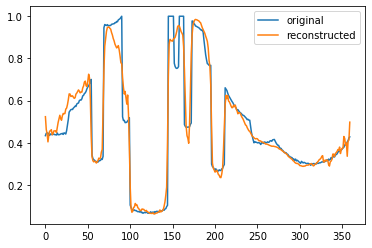

Epoch [91/100], Step [50/400], Loss: 0.008085
Epoch [91/100], Step [100/400], Loss: 0.007813
Epoch [91/100], Step [150/400], Loss: 0.008241
Epoch [91/100], Step [200/400], Loss: 0.008026
Epoch [91/100], Step [250/400], Loss: 0.008485
Epoch [91/100], Step [300/400], Loss: 0.007971
Epoch [91/100], Step [350/400], Loss: 0.008117
Epoch [91/100], Step [400/400], Loss: 0.008132
Epoch [91/100], Average Train Loss: 0.008029, Average Test Loss: 0.007994
Epoch [92/100], Step [50/400], Loss: 0.007759
Epoch [92/100], Step [100/400], Loss: 0.008189
Epoch [92/100], Step [150/400], Loss: 0.007996
Epoch [92/100], Step [200/400], Loss: 0.007838
Epoch [92/100], Step [250/400], Loss: 0.007812
Epoch [92/100], Step [300/400], Loss: 0.008190
Epoch [92/100], Step [350/400], Loss: 0.007926
Epoch [92/100], Step [400/400], Loss: 0.007644
Epoch [92/100], Average Train Loss: 0.008014, Average Test Loss: 0.008113
Epoch [93/100], Step [50/400], Loss: 0.007743
Epoch [93/100], Step [100/400], Loss: 0.008060
Epoch [93

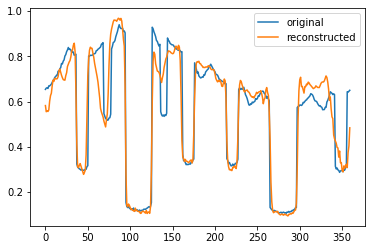

Epoch [96/100], Step [50/400], Loss: 0.007897
Epoch [96/100], Step [100/400], Loss: 0.007824
Epoch [96/100], Step [150/400], Loss: 0.007947
Epoch [96/100], Step [200/400], Loss: 0.008125
Epoch [96/100], Step [250/400], Loss: 0.007946
Epoch [96/100], Step [300/400], Loss: 0.008085
Epoch [96/100], Step [350/400], Loss: 0.008067
Epoch [96/100], Step [400/400], Loss: 0.008025
Epoch [96/100], Average Train Loss: 0.007933, Average Test Loss: 0.008014
Epoch [97/100], Step [50/400], Loss: 0.007594
Epoch [97/100], Step [100/400], Loss: 0.007973
Epoch [97/100], Step [150/400], Loss: 0.008037
Epoch [97/100], Step [200/400], Loss: 0.007764
Epoch [97/100], Step [250/400], Loss: 0.007820
Epoch [97/100], Step [300/400], Loss: 0.007962
Epoch [97/100], Step [350/400], Loss: 0.008214
Epoch [97/100], Step [400/400], Loss: 0.007753
Epoch [97/100], Average Train Loss: 0.007923, Average Test Loss: 0.008132
Epoch [98/100], Step [50/400], Loss: 0.007985
Epoch [98/100], Step [100/400], Loss: 0.007808
Epoch [98

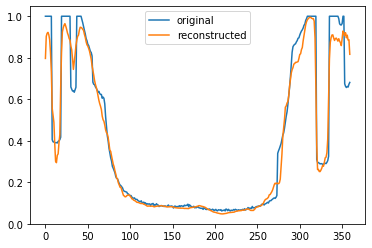

In [15]:
num_epochs = 100

for epoch in range(num_epochs):
    train_total_loss = 0.
    test_total_loss = 0.
    for i, [img] in enumerate(train_data_loader):
        outputs = autoencoder(img)
        loss = cirterion(outputs, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()
        if (i + 1) % 50 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_data_loader)}], Loss: {loss.item():.6f}")
    with torch.no_grad():
        for [img] in test_data_loader:
          outputs = autoencoder(img)
          loss = cirterion(outputs, img)
          test_total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}]"
            f", Average Train Loss: {train_total_loss / len(train_data_loader):.6f}"
            f", Average Test Loss: {test_total_loss / len(test_data_loader):.6f}")
    if (epoch + 1) % 5 == 0:
        plot_result()

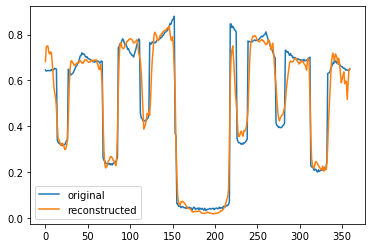

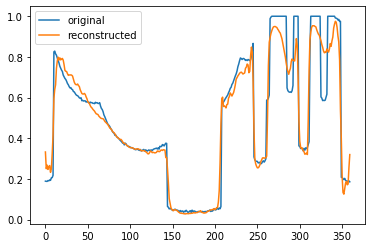

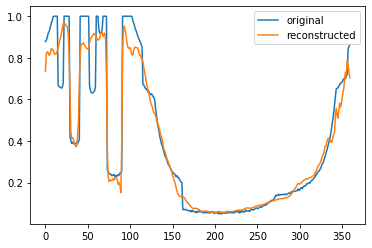

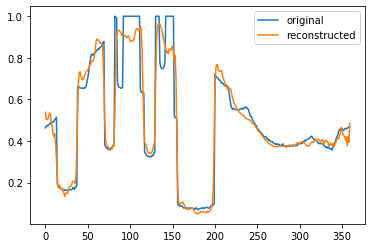

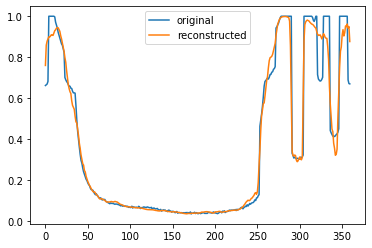

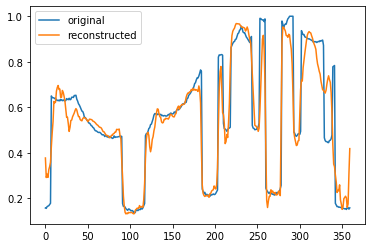

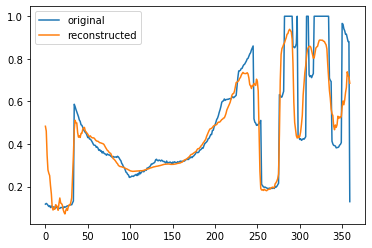

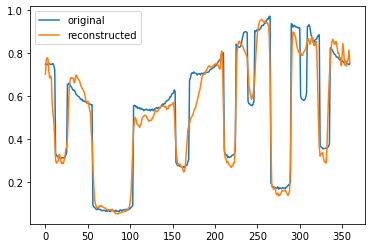

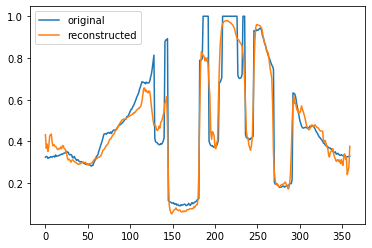

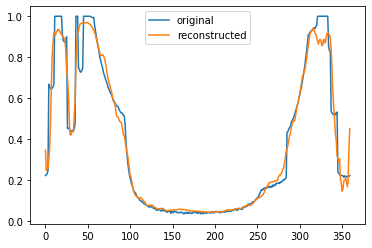

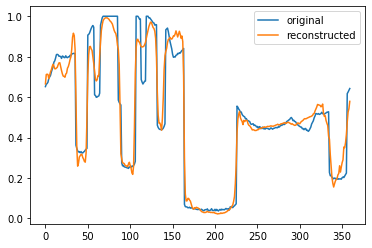

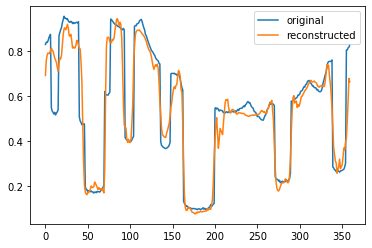

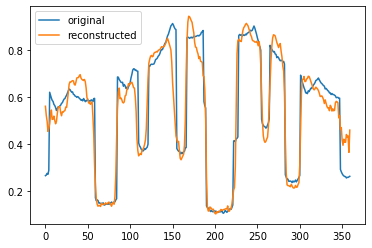

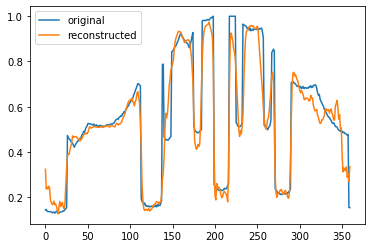

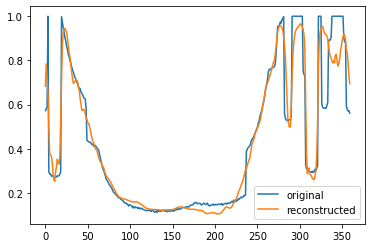

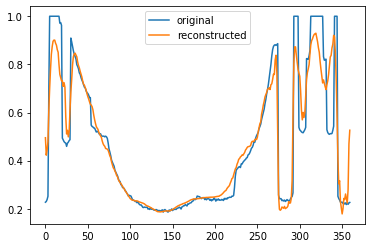

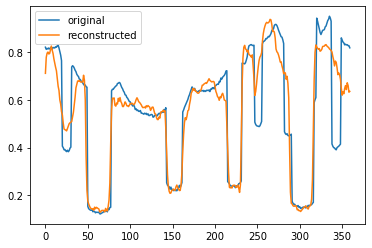

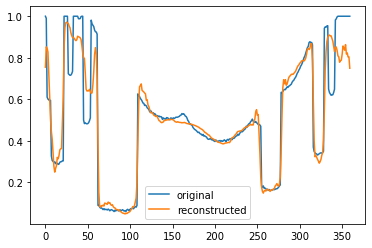

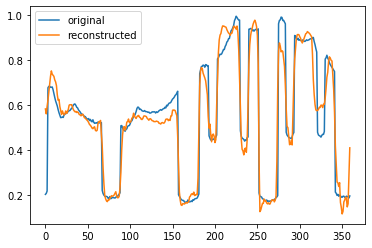

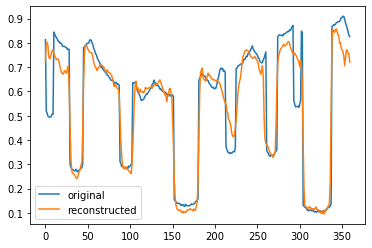

In [16]:
for _ in range(20):
  plot_result()

In [23]:
# TODO move const
weight_dir = "/home/asad/catkin_ws2/src/turtlebot3_activeSLAM/dqn_controller/weights/"

torch.save(autoencoder.state_dict(), weight_dir + "scan_autoencoder_weight " + str(datetime.datetime.now())[:19])

In [24]:
weight_path = weight_dir + sorted([w for w in os.listdir(weight_dir) if "scan_autoencoder" in w])[-1]
weight_path

'/home/asad/catkin_ws2/src/turtlebot3_activeSLAM/dqn_controller/weights/scan_autoencoder_weight 2023-07-28 22:09:11'

In [25]:
model = AutoencoderScan360()
model.load_state_dict(torch.load(weight_path))
model = model.to(device)

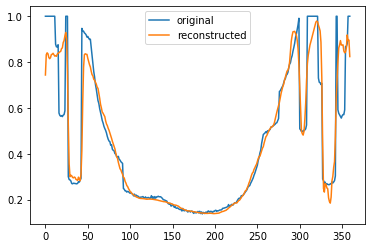

In [26]:
index = np.random.randint(len(test_data))

with torch.no_grad():
    result = model(test_data[index])

plt.plot(test_data[index].cpu().squeeze(), label="original")
plt.plot(result[0].cpu().squeeze(), label="reconstructed")

plt.legend()
plt.show()
